In [145]:
import pandas as pd
import numpy as np
import math


def ewm(df):
    df = df.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))
    rows, cols = df.shape
    k = 1.0 / math.log(rows)

    p = df / df.sum(axis=0)
    lnf = -np.log(p, where=df != 0) * p * k

    d = 1 - lnf.sum(axis=0)
    w = d / d.sum()

    w = pd.DataFrame(w)
    w = w.round(5)
    w.index = df.columns
    w.columns = ['weight']
    return w


weight = [0.01499,
          0.01371,
          0.42419,
          0.01306,
          0.00821,
          0.01341,
          0.00913,
          0.4914,
          0.01189]



In [146]:
# 计算原始政策评分

data = pd.read_excel(
    r"E:\Programing\PycharmProjects\2022MCM-B\Q3\数据\Q3数据.xlsx")  #The path and the name of the file

data = data.set_index('年')
myWeight = ewm(data)
newWeight = (np.array(weight) + np.array(myWeight['weight'].tolist())) / 2

data = data.values
data = (data - data.min(axis=0)) / (data.ptp(axis=0))
scatter = np.sum(data * newWeight, axis=1)
scatter

array([0.49017328, 0.50112091, 0.48079766, 0.45804368, 0.46571229,
       0.43584049, 0.41113744, 0.39615033, 0.39164528, 0.40225259,
       0.37001265, 0.34647663, 0.29244431, 0.32127201, 0.29938097,
       0.30940821, 0.34080498, 0.31157274, 0.36854881, 0.34630598,
       0.35917627, 0.43137373, 0.42953496, 0.41601134, 0.39553708,
       0.34073187, 0.3532953 , 0.42946136, 0.40321163, 0.45101645])

In [147]:
# 计算优化政策得分

data = pd.read_excel(
    r"E:\Programing\PycharmProjects\2022MCM-B\Q3\数据\Q3数据.xlsx",
    sheet_name='优化政策')  #The path and the name of the file

data = data.set_index('年')
idx = data.index
myWeight = ewm(data)
newWeight = (np.array(weight) + np.array(myWeight['weight'].tolist())) / 2

data = data.values
data = (data - data.min(axis=0)) / (data.ptp(axis=0))
scatterTuning = np.sum(data * newWeight, axis=1)
scatterTuning


array([0.48677231, 0.4965132 , 0.47710366, 0.4566589 , 0.46514574,
       0.43649124, 0.41376679, 0.39941302, 0.39566452, 0.40705988,
       0.37665177, 0.35513828, 0.30460753, 0.33064902, 0.31075595,
       0.31986631, 0.35330417, 0.2999559 , 0.38376457, 0.36373163,
       0.37896428, 0.4507721 , 0.44979233, 0.4378529 , 0.41996859,
       0.36714344, 0.381558  , 0.45933512, 0.43553514, 0.45510846])

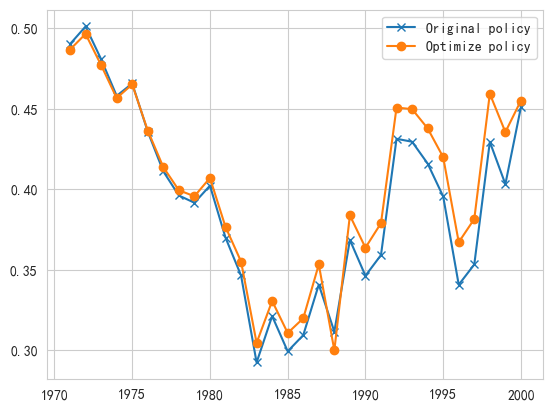

In [238]:
scatter_ = scatter = pd.DataFrame(scatter, index=idx)
scatterTuning_ = scatterTuning = pd.DataFrame(scatterTuning, index=idx)
x = scatter.index.tolist()

# 对比二者指标

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, scatter, marker='x', label='Original policy')
ax.plot(x, scatterTuning, marker='o', label='Optimize policy')

plt.legend()
plt.savefig('Optimize policy vs Original policy.svg')
plt.show()

可以得出优化政策总体是要好于原政策的

In [149]:
def TDGM(x):
    x0 = x.copy()
    x1 = np.array([np.sum(x0[:i + 1]) for i in range(x0.shape[0])])
    z1 = np.array([(x1[i] + x1[i + 1]) / 2 for i in range(x1.shape[0] - 1)])
    Y = x0[1:][:, None]
    B = np.c_["1", -z1[:, None], np.arange(2, x0.shape[0] + 1)[:, None], np.ones((x0.shape[0] - 1, 1))]
    p = np.linalg.inv(B.T @ B) @ B.T @ Y
    a, b, c = p.T[0]
    alf = x0[0] * ((1 - 0.5 * a) / (1 + 0.5 * a) - 1) + 2 * b / (1 + 0.5 * a) + c / (1 + 0.5 * a)
    bata = (1 - 0.5 * a) / (1 + 0.5 * a)
    gam = b / (1 + 0.5 * a)
    return alf, bata, gam

In [150]:
from scipy.interpolate import make_interp_spline, interp1d


def smooth_xy(x_value: np.ndarray, y_value: np.ndarray, funSmooth):
    model = funSmooth(x_value, y_value)
    x_smooth = np.linspace(x_value.min(), x_value.max(), 500)
    y_smooth = model(x_smooth)
    return x_smooth, y_smooth

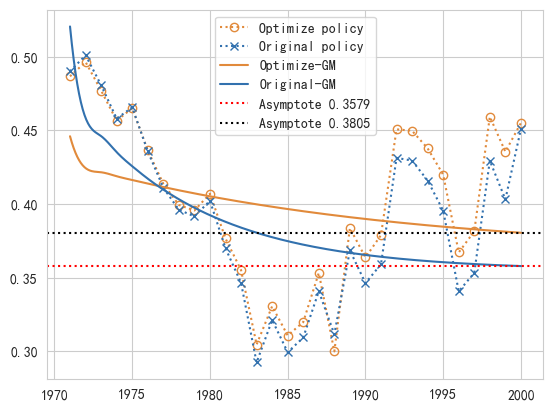

In [178]:
func = lambda k, *a: a[0] * a[1] ** (k - 2) + np.sum([a[2] * a[1] ** i for i in range(0, k - 2)])
prex1 = np.array([func(i, *TDGM(scatter[0].values)) for i in range(1, scatter[0].values.shape[0] + 1)])
prex2 = np.array([func(i, *TDGM(scatterTuning[0].values)) for i in range(1, scatterTuning[0].values.shape[0] + 1)])

fig, ax = plt.subplots()
ax.plot(x, scatterTuning_, ls=':', mfc="None", marker='o', label='Optimize policy', color='#e18a3b')
ax.plot(x, scatter_, ls=':', marker='x', label='Original policy', color='#3271ae')

# 平滑处理
_, prex1Smooth = smooth_xy(idx, prex1, make_interp_spline)
x_, prex2Smooth = smooth_xy(idx, prex2, make_interp_spline)
ax.plot(x_, prex2Smooth, label='Optimize-GM', color='#e18a3b')
ax.plot(x_, prex1Smooth, label='Original-GM', color='#3271ae')

ax.axhline(y=prex1Smooth[-1], ls=":", color="r", label=f'Asymptote {round(prex1Smooth[-1], 4)}')
ax.axhline(y=prex2Smooth[-1], ls=":", color="k", label=f'Asymptote {round(prex2Smooth[-1], 4)}')

plt.legend()
plt.savefig('forecast.svg')
plt.show()

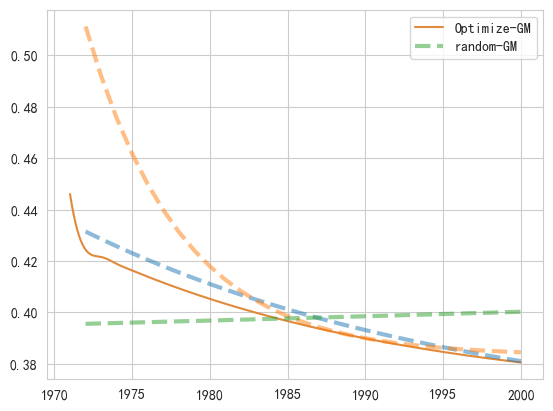

In [237]:
# 灵敏度

np.random.seed()
ff1 = np.sum(newWeight * (data + np.random.randn(data.shape[0], data.shape[1]) * 0.1), axis=1)
ff2 = np.sum(newWeight * (data + np.random.randn(data.shape[0], data.shape[1]) * 0.1), axis=1)
ff3 = np.sum(newWeight * (data + np.random.randn(data.shape[0], data.shape[1]) * 0.1), axis=1)

prexff1 = np.array([func(i, *TDGM(ff1)) for i in range(2, scatter[0].values.shape[0] + 1)])
prexff2 = np.array([func(i, *TDGM(ff2)) for i in range(2, scatter[0].values.shape[0] + 1)])
prexff3 = np.array([func(i, *TDGM(ff3)) for i in range(2, scatter[0].values.shape[0] + 1)])

xdata = np.r_["0", [ff1], [ff2], [ff3]]
prexdata = np.r_["0", [prexff1], [prexff2], [prexff3]]

fig, ax = plt.subplots()

# for i in range(1, xdata.shape[0]):
#     ax.plot(x, xdata[i], ls=":", marker="o", ms=10, mec="None", alpha=0.5)

ax.plot(x_, prex2Smooth, label='Optimize-GM', color='#e18a3b')
for i in range(1, prexdata.shape[0]):
    ax.plot(x[1:], prexdata[i], alpha=0.5, lw=3, ls="--")
ax.plot(x[1:],prexdata[0],alpha=0.5,lw=3,ls="--",label="random-GM")

plt.legend()
plt.savefig('sensitivityAnalysis.svg')
plt.show()